<a href="https://colab.research.google.com/github/tiara070403/skripsi/blob/main/skripsifiks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary packages
!pip install Sastrawi
!pip install tweet-preprocessor
!pip install textblob
!pip install wordcloud
!pip install nltk

# Import libraries
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('punkt')
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import pipeline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
df = pd.read_csv('/content/crawling.csv', index_col=0)

In [3]:
df_copy = df.copy()

In [4]:
df = df[['created_at', 'full_text']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5349 entries, 1858070162362204643 to 1230765438897815552
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  5349 non-null   object
 1   full_text   5349 non-null   object
dtypes: object(2)
memory usage: 125.4+ KB


In [6]:
df['full_text'] = df['full_text'].astype(str).str.lower()  # Mengubah teks menjadi lowercase
df['full_text'] = df['full_text'].replace('false', pd.NA)
df = df.dropna(subset=['full_text'])

In [7]:
df = df.drop_duplicates(subset=['full_text'])

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df = df.dropna()

In [10]:
df.isnull().sum()

,0
created_at,0
full_text,0


In [11]:
df.isnull().sum()

,0
created_at,0
full_text,0


In [12]:
# Case Folding
df['full_text'] = df['full_text'].str.lower()
df

,created_at,full_text
conversation_id_str,,
1858070162362204643,Sun Nov 17 08:50:22 +0000 2024,lucu banget mahasiswa pencinta alam ini
1846529554657239219,Wed Oct 16 12:32:07 +0000 2024,bejat mahasiswa pencinta alam di jambi 'genjot...
1467691301155979267,Wed Oct 09 13:58:44 +0000 2024,@leonita_lestari ada perkoempoelan pentjinta a...
1836014724523458593,Tue Sep 17 12:09:56 +0000 2024,[press release sowan ukm ke ukm unit pandu lin...
1835164951125917967,Sun Sep 15 03:53:14 +0000 2024,[press release sowan ukm ke ukm unit pandu lin...
...,...,...
1230768955653967873,Fri Feb 21 08:19:20 +0000 2020,setiap orang di dunia ini bisa menjadi #betheh...
1230767649816100868,Fri Feb 21 08:14:08 +0000 2020,kapolri: pelestarian lingkungan merupakan tang...
1230765718263586818,Fri Feb 21 08:06:28 +0000 2020,pelestarian lingkungan merupakan tanggung jawa...


In [13]:
# Cleaning
def clean_twitter_text(text):
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  text = re.sub(r'#\w+', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?://\S+', '', text)

  text = re.sub(r'[^A-Za-z0-9 ]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()

  return text

df['full_text'] = df['full_text'].apply(clean_twitter_text)

In [14]:
df.shape

(5246, 2)

In [15]:
def filter_tokens_by_length(df, column, min_words, max_words):

    words_count = df[column].astype(str).apply(lambda x: len(x.split()))

    mask = (words_count >= min_words) & (words_count <= max_words)

    filtered_df = df[mask]
    return filtered_df

min_words = 3
max_words = 4000
df = filter_tokens_by_length(df, 'full_text', min_words, max_words)

In [16]:
# Normalisasi Data
norm = {'kekekekegiatanananan':'kegiatan', 'press release': 'siaran pers', 'ukamu': 'unit kegiatan mahasiswa', 'giat': 'kegiatan', 'luring': 'luring', 'sekre': 'sekretariat', 'mapala': 'mahasiswa pencinta alam', 'kocak': 'lucu', 'enak': 'enak', 'bilang': 'bilang', 'sowan': 'mengunjungi', 'buka': 'membuka', 'sampai': 'hingga', 'pukul': 'jam', 'sd': 'sampai', 'kapan': 'kapan', 'mau': 'ingin', 'join': 'bergabung', 'sama': 'bersama', 'bisa': 'dapat', 'bantu': 'membantu', 'kamu': 'kamu', 'sama': 'bersama', 'bisa': 'dapat', 'sama': 'bersama', ' mikir2 ':' mikir ', 'perkoempoelan':'perkumpulan', 'sowan':'menghadap', 'genjot':'menyerang', 'wkwkw':'hahaha', 'gtgtgt':'.', 'th':'tahun', 'ukamu':'ukm', 'bejat':'rusak', 'pentjinta':'pencinta', 'pecinta':'pencinta', ' siaaapp ':' siap ', 'okaaay ':'oke ', 'udh ':'sudah ','ga ':'tidak ',' gaskeun':' ayo ', 'wowww ':'wow ', ' haaayyuukkk ':' ayo ', ' yg ':' yang ', ' udh ':' udah ', 'wkwk ':' ', ' min ':' kak ', ' malem ':' malam', ' malem2 ':' malam ', ' sm ':' sama ', ' dy ':' dia ', ' lg ':' lagi ', ' skrg ':' sekarang ', ' ddpn ':' didepan ', ' makasi ':' makasih ', ' pertamaz ':' pertamax ', ' jg ':' juga ', ' donk ':' dong ', ' ikutann ':' ikutan ', ' banyakk ':' banyak ', ' twt ':' tweet', 'mantaap ':'mantap ', ' juarak':' juara ', 'daridulu ':'dari dulu ', 'siapp ':'siap ', ' gamau ':' tidak mau ', ' sll ':' selalu ', ' qu ':' aku ', ' krn ':' karena ', ' irii':' iri', ' muluu ':' terus ', 'mada ':'masa ', 'jgn ':'jangan ', ' jgn ':' jangan ', ' muluuu ':' terus ', 'ntar ':'nanti ', ' awtnya':' awetnya', 'gg ':'keren ', ' kerennn':' keren ', ' bisaa ':' bisa ', 'gaaa':'tidak ', " yg ": " yang ", ' nyampe':' sampai', ' nyampe ':' sampai ', ' lu ':' kamu ', ' ikhlaaasss ':' ikhlas ', ' gak ':' tidak ', ' klo ':' kalo ', ' amp ': ' sampai ', ' ga ':' tidak ', ' yaaaa':' ya ', 'betolll ':'betul ', ' kaga ':' tidak ', ' idk ':' tidak tahu ', ' jkt ':' jakarta ', ' lo ':' kamu ', ' bjir ':' ', ' kek ':' seperti ', ' yg ':' yang ', ' utk ':' untuk ', 'kismin ':'miskin ', ' kismin ':' miskin ', ' pd ':' pada ', ' dgn ':' dengan ', ' ituu ':' itu ', ' jg ':' juga ', 'yoi':'iya ', ' yoi ':' iya ', 'org2 ':'orang ', ' tak ':' tidak ', ' kyk ':' seperti ', ' sbg ':' sebagai ', ' anjjjj ':' ', ' bgt ':' banget ', 'km ':'kamu ', ' km ':' kamu', ' byk ':' banyak ', ' lg ':' lagi ', ' mrk ':' mereka ', ' blm ':' belum '}

def normalisasi(str_text):
  for i in norm:
    str_text = str_text.replace(i, norm[i])
  return str_text

df['full_text'] = df['full_text'].apply(lambda x: normalisasi(x))
df

/tmp/ipython-input-16-266047071.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df['full_text'].apply(lambda x: normalisasi(x))


,created_at,full_text
conversation_id_str,,
1858070162362204643,Sun Nov 17 08:50:22 +0000 2024,lucu banget mahasiswa pencinta alam ini
1846529554657239219,Wed Oct 16 12:32:07 +0000 2024,rusak mahasiswa pencinta alam di jambi menyera...
1467691301155979267,Wed Oct 09 13:58:44 +0000 2024,ada perkumpulan pencinta alam yang lahir tahun...
1836014724523458593,Tue Sep 17 12:09:56 +0000 2024,siaran pers menghadap ukamu ke ukamu unit pand...
1835164951125917967,Sun Sep 15 03:53:14 +0000 2024,siaran pers menghadap ukamu ke ukamu unit pand...
...,...,...
1230768955653967873,Fri Feb 21 08:19:20 +0000 2020,setiap orang di dunia ini dapat menjadi untuk ...
1230767649816100868,Fri Feb 21 08:14:08 +0000 2020,kapolri pelestarian lingkungan merupakan tangg...
1230765718263586818,Fri Feb 21 08:06:28 +0000 2020,pelestarian lingkungan merupakan tanggung jawa...


In [17]:
# Stopwords Removal
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
more_stop_words = ['anjayyy']

stop_words = StopWordRemoverFactory().get_stop_words()
stop_words.extend(more_stop_words)

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df['full_text'] = df['full_text'].apply(lambda x: stopword(x))
df

/tmp/ipython-input-17-522788599.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['full_text'] = df['full_text'].apply(lambda x: stopword(x))


,created_at,full_text
conversation_id_str,,
1858070162362204643,Sun Nov 17 08:50:22 +0000 2024,lucu banget mahasiswa pencinta alam
1846529554657239219,Wed Oct 16 12:32:07 +0000 2024,rusak mahasiswa pencinta alam jambi menyerang ...
1467691301155979267,Wed Oct 09 13:58:44 +0000 2024,perkumpulan pencinta alam lahir tahun 1953 did...
1836014724523458593,Tue Sep 17 12:09:56 +0000 2024,siaran pers menghadap ukamu ukamu unit pandu l...
1835164951125917967,Sun Sep 15 03:53:14 +0000 2024,siaran pers menghadap ukamu ukamu unit pandu l...
...,...,...
1230768955653967873,Fri Feb 21 08:19:20 +0000 2020,orang dunia dapat menjadi lingkungan sekitarny...
1230767649816100868,Fri Feb 21 08:14:08 +0000 2020,kapolri pelestarian lingkungan merupakan tangg...
1230765718263586818,Fri Feb 21 08:06:28 +0000 2020,pelestarian lingkungan merupakan tanggung jawa...


In [18]:
# Tokenisasi
tokenized = df['full_text'].apply(lambda x:x.split())
df

,created_at,full_text
conversation_id_str,,
1858070162362204643,Sun Nov 17 08:50:22 +0000 2024,lucu banget mahasiswa pencinta alam
1846529554657239219,Wed Oct 16 12:32:07 +0000 2024,rusak mahasiswa pencinta alam jambi menyerang ...
1467691301155979267,Wed Oct 09 13:58:44 +0000 2024,perkumpulan pencinta alam lahir tahun 1953 did...
1836014724523458593,Tue Sep 17 12:09:56 +0000 2024,siaran pers menghadap ukamu ukamu unit pandu l...
1835164951125917967,Sun Sep 15 03:53:14 +0000 2024,siaran pers menghadap ukamu ukamu unit pandu l...
...,...,...
1230768955653967873,Fri Feb 21 08:19:20 +0000 2020,orang dunia dapat menjadi lingkungan sekitarny...
1230767649816100868,Fri Feb 21 08:14:08 +0000 2020,kapolri pelestarian lingkungan merupakan tangg...
1230765718263586818,Fri Feb 21 08:06:28 +0000 2020,pelestarian lingkungan merupakan tanggung jawa...


In [19]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(full_text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in full_text:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)
data_clean = pd.read_csv('/content/preprocessing.csv', encoding='latin1')


lucu banget mahasiswa cinta alam
rusak mahasiswa cinta alam jambi serang paksa teman kampus rekam
kumpul cinta alam lahir tahun 1953 diri awibowo jutidak terbit majalah cinta alam sehingtidak istilah cinta alam familiar masyarakat jauh soe hok gie diri mahasiswa cinta alam univ indonesia
siar pers hadap ukamu ukamu unit pandu lingkung mahasiswa cinta alam halo gensoed langsung kekegiatanan menteri negeri bem unsoed hadap upl mpa jumat 13 september 2024 jam 1900 2050 wib luring sekretariat upl mpa
siar pers hadap ukamu ukamu unit pandu lingkung mahasiswa cinta alam halo gensoed langsung kekegiatanan menteri negeri bem unsoed hadap upl mpa jumat 13 september 2024 jam 1900 2050 wib luring sekretariat upl mpa
mahasiswa cinta alam mahasiswa cinta alam macam apa kamu lucu negara udah obok obok rezim enak nya elu bilang orang demo ikut ikut di tunggang politik dih padahal anak kuliah loh tingkah e kaya napak tanah pikir ngtidak berimpact hidup kampus
mapagama tapak bumi andalas 12 hari panjat

KeyboardInterrupt: 

In [20]:
df = pd.read_csv('/content/preprocessing.csv')

In [21]:
df_copy = df.copy()

In [22]:
df = pd.read_csv('/content/labelingg.csv')

In [23]:
# Labeling
sentimen = []
for index, row in df_copy.iterrows():
  if row['full_text'] == 1 or row['full_text'] == 2:
    sentimen.append(0)
  else :
    sentimen.append(1)

In [24]:
df_copy['sentimen'] = sentimen

In [25]:
df_copy.head()
df

,full_text,sentimen
0,lucu banget mahasiswa cinta alam,positive
1,rusak mahasiswa cinta alam jambi serang paksa ...,neutral
2,kumpul cinta alam lahir tahun 1953 diri awibow...,negative
3,siar pers hadap ukamu ukamu unit pandu lingkun...,neutral
4,mahasiswa cinta alam mahasiswa cinta alam maca...,negative
...,...,...
4757,betul lestari lingkung tanggung jawab semua,positive
4758,lestari lingkung rupa tanggung jawab moral sama,positive
4759,orang dunia dapat jadi lingkung sekitar terap ...,positive
4760,kapolri lestari lingkung rupa tanggung jawab m...,neutral


In [26]:
sentimen_counts = df.sentimen.value_counts()
sentimen_counts

,count
sentimen,
neutral,2122
positive,1846
negative,794


In [27]:
df.shape

(4762, 2)

In [28]:
# Menggabungkan kedua attribut
at1 = pd.read_csv('/content/labelingg.csv')
at2 = pd.read_csv('/content/crawling.csv')

# Assuming 'full_text' and 'sentimen' are the relevant columns
result = at1[['full_text', 'sentimen']].copy()

In [29]:
result.head()

,full_text,sentimen
0,lucu banget mahasiswa cinta alam,positive
1,rusak mahasiswa cinta alam jambi serang paksa ...,neutral
2,kumpul cinta alam lahir tahun 1953 diri awibow...,negative
3,siar pers hadap ukamu ukamu unit pandu lingkun...,neutral
4,mahasiswa cinta alam mahasiswa cinta alam maca...,negative


In [30]:
df.shape

(4762, 2)

In [31]:
# Menghitung Kata Dengan TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [32]:
full_text = result['full_text']
sentimen = result['sentimen']

In [33]:
full_text.isnull().sum()

np.int64(0)

In [34]:
full_text = full_text.fillna('tidak ada komentar')

In [35]:
cv = CountVectorizer()
term_fit = cv.fit(full_text)

print(len(term_fit.vocabulary_))

12074


In [36]:
term_fit.vocabulary_

{'lucu': 6372,
 'banget': 1304,
 'mahasiswa': 6485,
 'cinta': 2244,
 'alam': 659,
 'rusak': 9383,
 'jambi': 4761,
 'serang': 9870,
 'paksa': 8120,
 'teman': 10874,
 'kampus': 5148,
 'rekam': 9132,
 'kumpul': 5925,
 'lahir': 6007,
 'tahun': 10617,
 '1953': 137,
 'diri': 2822,
 'awibowo': 1150,
 'jutidak': 5017,
 'terbit': 10929,
 'majalah': 6509,
 'sehingtidak': 9683,
 'istilah': 4680,
 'familiar': 3330,
 'masyarakat': 6769,
 'jauh': 4810,
 'soe': 10186,
 'hok': 4260,
 'gie': 3735,
 'univ': 11433,
 'indonesia': 4503,
 'siar': 9984,
 'pers': 8463,
 'hadap': 3930,
 'ukamu': 11329,
 'unit': 11431,
 'pandu': 8171,
 'lingkung': 6240,
 'halo': 4003,
 'gensoed': 3697,
 'langsung': 6064,
 'kekegiatanan': 5369,
 'menteri': 6922,
 'negeri': 7444,
 'bem': 1500,
 'unsoed': 11461,
 'upl': 11493,
 'mpa': 7152,
 'jumat': 4986,
 '13': 80,
 'september': 9861,
 '2024': 202,
 'jam': 4755,
 '1900': 129,
 '2050': 205,
 'wib': 11827,
 'luring': 6398,
 'sekretariat': 9718,
 'macam': 6432,
 'apa': 919,
 'kamu'

In [37]:
term_frequency_all = term_fit.transform(full_text)
print(term_frequency_all)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 71122 stored elements and shape (4762, 12074)>
  Coords	Values
  (0, 659)	1
  (0, 1304)	1
  (0, 2244)	1
  (0, 6372)	1
  (0, 6485)	1
  (1, 659)	1
  (1, 2244)	1
  (1, 4761)	1
  (1, 5148)	1
  (1, 6485)	1
  (1, 8120)	1
  (1, 9132)	1
  (1, 9383)	1
  (1, 9870)	1
  (1, 10874)	1
  (2, 137)	1
  (2, 659)	4
  (2, 1150)	1
  (2, 2244)	4
  (2, 2822)	2
  (2, 3330)	1
  (2, 3735)	1
  (2, 4260)	1
  (2, 4503)	1
  (2, 4680)	1
  :	:
  (4759, 6022)	1
  (4759, 6061)	1
  (4759, 6189)	1
  (4759, 6240)	2
  (4759, 7981)	1
  (4759, 9712)	1
  (4759, 9736)	1
  (4759, 10402)	1
  (4759, 10927)	1
  (4760, 4814)	1
  (4760, 5198)	1
  (4760, 6189)	1
  (4760, 6240)	1
  (4760, 7131)	1
  (4760, 9379)	1
  (4760, 9486)	1
  (4760, 10721)	1
  (4761, 4814)	1
  (4761, 5198)	1
  (4761, 6189)	1
  (4761, 6240)	1
  (4761, 7131)	1
  (4761, 9379)	1
  (4761, 9801)	1
  (4761, 10721)	1


In [38]:
full_text_tf = full_text[1]
print(full_text_tf)

rusak mahasiswa cinta alam jambi serang paksa teman kampus rekam


In [39]:
term_frequency = term_fit.transform([full_text_tf])
print(term_frequency)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 10 stored elements and shape (1, 12074)>
  Coords	Values
  (0, 659)	1
  (0, 2244)	1
  (0, 4761)	1
  (0, 5148)	1
  (0, 6485)	1
  (0, 8120)	1
  (0, 9132)	1
  (0, 9383)	1
  (0, 9870)	1
  (0, 10874)	1


In [40]:
dokumen = term_fit.transform(full_text)
tfidf_transformer = TfidfTransformer().fit(dokumen)
print(tfidf_transformer.idf_)

tfidf = tfidf_transformer.transform(term_frequency)
print(tfidf)

[8.77548582 8.77548582 8.08233864 ... 8.77548582 8.77548582 8.77548582]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10 stored elements and shape (1, 12074)>
  Coords	Values
  (0, 659)	0.08827090056623516
  (0, 2244)	0.09119739517993856
  (0, 4761)	0.3962795934123765
  (0, 5148)	0.2564941448026988
  (0, 6485)	0.09221650848798388
  (0, 8120)	0.42831298323393796
  (0, 9132)	0.42831298323393796
  (0, 9383)	0.35010327762052706
  (0, 9870)	0.3905376215858637
  (0, 10874)	0.3325126677687165


In [41]:
train_s0 = df_copy[df_copy["sentimen"] == 0]

In [42]:
train_s0["full_text"] = train_s0["full_text"].fillna("tidak ada komentar")

In [43]:
df.shape

(4762, 2)

In [44]:
train_s0.head()

,full_text,sentimen


In [45]:
df

,full_text,sentimen
0,lucu banget mahasiswa cinta alam,positive
1,rusak mahasiswa cinta alam jambi serang paksa ...,neutral
2,kumpul cinta alam lahir tahun 1953 diri awibow...,negative
3,siar pers hadap ukamu ukamu unit pandu lingkun...,neutral
4,mahasiswa cinta alam mahasiswa cinta alam maca...,negative
...,...,...
4757,betul lestari lingkung tanggung jawab semua,positive
4758,lestari lingkung rupa tanggung jawab moral sama,positive
4759,orang dunia dapat jadi lingkung sekitar terap ...,positive
4760,kapolri lestari lingkung rupa tanggung jawab m...,neutral


In [46]:
from wordcloud import WordCloud

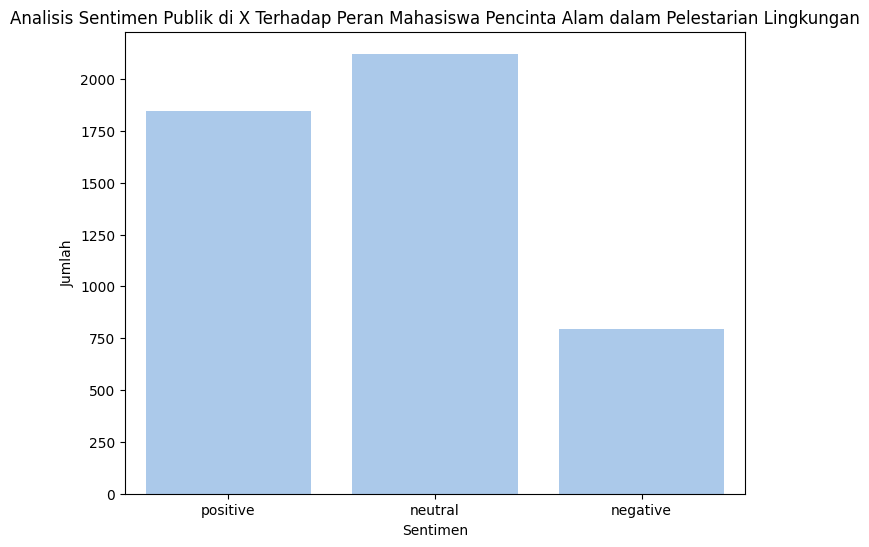

In [47]:
# Visualisasi
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("pastel")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentimen', data=df)
plt.title('Analisis Sentimen Publik di X Terhadap Peran Mahasiswa Pencinta Alam dalam Pelestarian Lingkungan')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [48]:
data_negatif = df[df['sentimen'] == 'negative']
data_positif = df[df['sentimen'] == 'positive']
data_netral = df[df['sentimen'] == 'neutral']

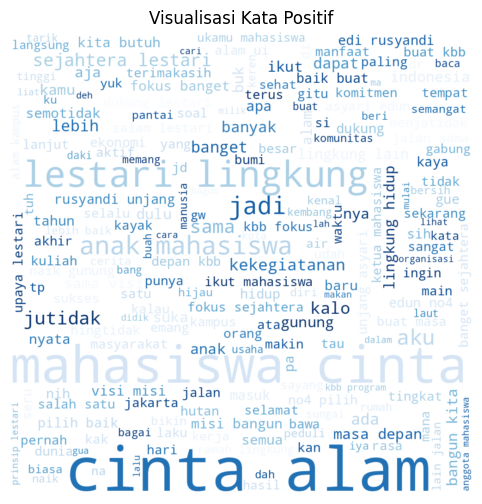

In [49]:
all_text_s1 = ' '.join(word for word in data_positif["full_text"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Visualisasi Kata Positif")
plt.margins(x=0, y=0)
plt.show()

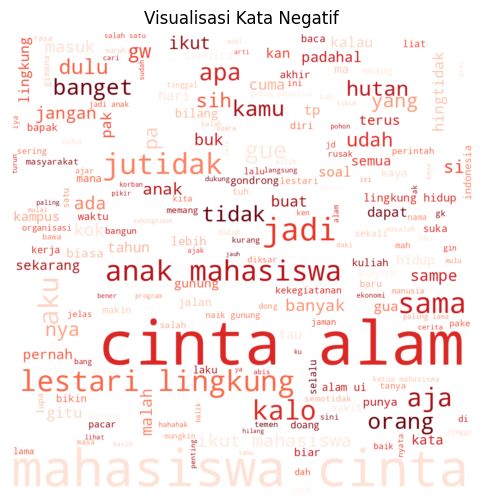

In [50]:
all_text_s0 = ' '.join(word for word in data_negatif["full_text"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Negatif")
plt.margins(x=0, y=0)
plt.show()

In [51]:
train_s1 = df_copy[df_copy["sentimen"] == 1]

In [52]:
train_s1["full_text"] = train_s1["full_text"].fillna("Tidak ada komentar")

In [53]:
train_s1.head()
df

,full_text,sentimen
0,lucu banget mahasiswa cinta alam,positive
1,rusak mahasiswa cinta alam jambi serang paksa ...,neutral
2,kumpul cinta alam lahir tahun 1953 diri awibow...,negative
3,siar pers hadap ukamu ukamu unit pandu lingkun...,neutral
4,mahasiswa cinta alam mahasiswa cinta alam maca...,negative
...,...,...
4757,betul lestari lingkung tanggung jawab semua,positive
4758,lestari lingkung rupa tanggung jawab moral sama,positive
4759,orang dunia dapat jadi lingkung sekitar terap ...,positive
4760,kapolri lestari lingkung rupa tanggung jawab m...,neutral


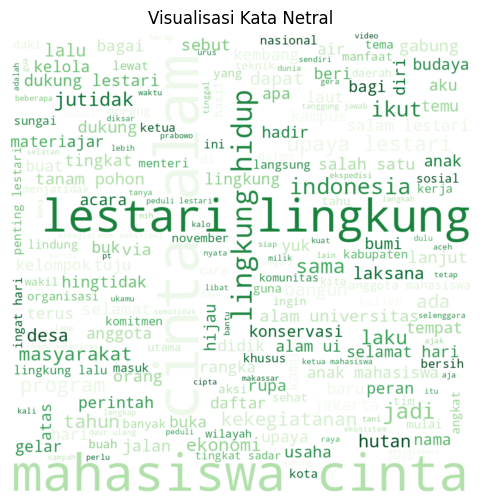

In [54]:
all_text_s2 = ' '.join(word for word in data_netral["full_text"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s2)
plt.figure(figsize=(9, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Visualisasi Kata Netral")
plt.margins(x=0, y=0)
plt.show()

In [55]:
# Split Data (TF-IDF)
result['full_text'] = result['full_text'].fillna("Tidak ada komentar")

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(result['full_text'], result['sentimen'],
                                                    test_size=0.1, stratify=result['sentimen'], random_state=30)

In [57]:
import numpy as np

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='replace', encoding='utf-8')

In [59]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(4285, 11396)
(477, 11396)


In [60]:
X_train = X_train.toarray()

In [61]:
X_test = X_test.toarray()

In [62]:
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

In [64]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

cv_method = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=999)

params_NB = {'var_smoothing': np.logspace(0, -9, num=100)}
gscv_nb = GridSearchCV(estimator=nb,
                        param_grid=params_NB,
                        cv = cv_method,
                        verbose = 1,
                        scoring = 'accuracy')

gscv_nb.fit(X_train, y_train)
gscv_nb.best_params_

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


{'var_smoothing': np.float64(0.01873817422860384)}

In [66]:
nb = GaussianNB(var_smoothing=0.01873817422860384)

In [67]:
nb.fit(X_train, y_train)

GaussianNB(var_smoothing=0.01873817422860384)

In [68]:
y_pred_nb = nb.predict(X_test)

In [77]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay

In [78]:
print('----- confusion matrix ------')
print(confusion_matrix(y_test, y_pred_nb))

print('----- classification report -----')
print(classification_report(y_test, y_pred_nb))

----- confusion matrix ------
[[ 52   9  18]
 [ 28 139  46]
 [ 70  19  96]]
----- classification report -----
              precision    recall  f1-score   support

    negative       0.35      0.66      0.45        79
     neutral       0.83      0.65      0.73       213
    positive       0.60      0.52      0.56       185

    accuracy                           0.60       477
   macro avg       0.59      0.61      0.58       477
weighted avg       0.66      0.60      0.62       477



In [83]:
plot_roc_curve(nb, X_test, y_test)

NameError: name 'plot_roc_curve' is not defined

In [84]:
X=df.full_text
y=df.sentimen

In [85]:
# TRAINING DATA
cvec=CountVectorizer()
tvec=TfidfVectorizer()
hvec=HashingVectorizer()

In [86]:
from sklearn.naive_bayes import MultinomialNB

clf1 = MultinomialNB()

In [87]:
model1 = Pipeline([('vectorizer',tvec)
                 ,('classifier',clf1)])

In [88]:
model1.fit(x_train,y_train)

NameError: name 'x_train' is not defined

In [ ]:
hasil1=model1.predict(x_test)

In [ ]:
matrix = classification_report(y_test,hasil1)
print('Classification report : \n',matrix)

In [ ]:
# TESTING
def classify_text(input_text):
    models = [
        ('MultinomialNB', model_multinomialNaiveBayes)
    ]

    results = {}

    for name, model in models:
        prediction = model.predict([input_text])
        results[name] = prediction[0]

    return results

In [ ]:
model_multinomialNaiveBayes = model1.fit(x_train, y_train)

In [ ]:
input_text = input("Masukkan teks yang ingin diklasifikasikan: ")

results = classify_text(input_text)

print("Input kata :", input_text)

print("\nHasil Klasifikasi:")
for model, prediction in results.items():
    print(f"{model}: {prediction}")